In [5]:
import os
import io
import json
import numpy as np
from glob import glob
import pandas as pd
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt

In [71]:
def load_csv(file):
    data = pd.read_csv(file)
    return data

def load_json(file):
    with open(file, 'r') as f:
        data = json.load(f)
    return data

def save_df(df, save_file_to=None):
    assert save_file_to is not None, 'save_file_to is None'
    df.to_csv(save_file_to, index=False)

class ProcessLogs:
    def __init__(self, pattern='./logs/*/*/*/rank_0/'):
        self.args_files = glob(pattern+'args.json')
        self.is_valid = len(self.args_files) > 0
        assert self.is_valid, f'''Invalid pattern: {pattern}, {len(self.args_files)} args json files found'''
        self.init()

    def init(self):
        self.results = {}
        num = len(self.args_files)
        for i in range(num):
            args = load_json(self.args_files[i])
            key, keys2values = self.args2key(args)
            
            csv_file = glob(self.args_files[i].replace('args.json', 'overall.csv'))
            if len(csv_file) == 0:
                ThroughPut = 0
                PeakGPUMemory_mean = 0
                PeakGPUMemory_std = 0
                BatchTime_mean = 0
                BatchTime_std = 0
            else:
                csv_file = csv_file[0]
                csv_data = load_csv(csv_file)
                ThroughPut = csv_data['fw_g'][2] if 'fw_g' in csv_data else csv_data['fb_g'][2]
                PeakGPUMemory_mean = csv_data['update_gp'][0]
                PeakGPUMemory_std = csv_data['update_gp'][1]
                BatchTime_mean = csv_data['batch_time'][0]
                BatchTime_std = csv_data['batch_time'][1]
            value = {
                'ThroughPut': ThroughPut,
                'PeakGPUMemory_mean': PeakGPUMemory_mean,
                'PeakGPUMemory_std': PeakGPUMemory_std,
                'BatchTime_mean': BatchTime_mean,
                'BatchTime_std': BatchTime_std,
                'args': args,
                'keys2values': keys2values
            }
            if key in self.results:
                # if ThroughPut < self.results[key]['ThroughPut']:
                #     print(key, value)
                #     continue
                key += f'_v{i}'
                print(f'Warning: key {key} already exists')
            self.results[key] = value

    def args2key(self, args: dict):
        dist_backend = args['dist_backend']
        gpus = args['gpus']
        model = args['model']
        img_size = args['img_size']
        batch_size = args['batch_size']
        exp_name = args['exp_name']
        
        ##### parallelism
        use_zero = args['use_zero']
        shardstrategy = args['shardstrategy'] # for zero
        nof = args['nof'] # for zero
        use_fp16 = args['use_fp16']
        use_pipeline = args['use_pipeline']
        keys = ['dist_backend', 'gpus', 'model', 'img_size', 'batch_size',
                'exp_name', 'use_zero', 'shardstrategy', 'nof', 'use_fp16', 'use_pipeline']
        keys2values = {k: args[k] for k in keys}
        
        key = f'{model}_{dist_backend}_gpus{gpus}_{batch_size}x{img_size}x{img_size}'
        if use_zero == 1:
            key += f'_zero_{shardstrategy}_nof{nof}'
        if use_fp16 == 1:
            key += '_fp16'
        if use_pipeline == 1:
            key += f'_pipeline'
        key += f'_{exp_name}'
        return key, keys2values

    def export_all(self, save_file_to=None):
        content = 'model,gpus,batch_size,img_size,zero,shardstrategy,nof,fp16,pipeline,ThroughPut,PeakGPUMemory_mean,PeakGPUMemory_std,BatchTime_mean,BatchTime_std\n'
        template = '{model},{gpus},{batch_size},{img_size},{use_zero},{shardstrategy},{nof},{use_fp16},{use_pipeline},{ThroughPut},{PeakGPUMemory_mean},{PeakGPUMemory_std},{BatchTime_mean},{BatchTime_std}\n'
        for key, val in self.results.items():
            dicts = deepcopy(val['keys2values'])
            for x in ['ThroughPut', 'PeakGPUMemory_mean', 'PeakGPUMemory_std', 'BatchTime_mean', 'BatchTime_std']:
                dicts[x] = val[x]
            content += template.format(**dicts)
        df = pd.read_csv(io.StringIO(content))
        save_df(df, save_file_to)
        return df



In [74]:
pl = ProcessLogs()
df = pl.export_all(save_file_to='./results.csv')
df.sort_values(by=['model', 'gpus', 'batch_size', 'img_size', 'zero', 'shardstrategy', 'nof', 'fp16', 'pipeline'], ascending=[True, True, True, True, True, True, True, True, True])

,model,gpus,batch_size,img_size,zero,shardstrategy,nof,fp16,pipeline,ThroughPut,PeakGPUMemory_mean,PeakGPUMemory_std,BatchTime_mean,BatchTime_std
25,darts,1,128,32,0,btss,0.0,1,0,107.8270,4292.1260,139.3001,1.1871,6.6248
15,darts,1,256,32,0,btss,0.0,1,0,308.7382,8055.3376,31.1715,0.8292,3.5955
16,darts,1,256,32,0,btss,0.0,1,0,334.9889,8055.3376,31.1715,0.7642,3.1750
17,darts,1,256,32,0,btss,0.0,1,0,310.4982,8055.3376,31.1715,0.8245,3.5666
18,darts,1,512,32,0,btss,0.0,1,0,326.5220,15148.9210,230.4104,1.5680,6.9954
19,darts,1,512,32,0,btss,0.0,1,0,290.6796,15148.9210,230.4104,1.7614,8.2774
20,darts,1,512,32,0,btss,0.0,1,0,456.2834,15148.9210,230.4104,1.1221,4.0481
21,darts,1,512,32,0,btss,0.0,1,0,332.9421,15148.9210,230.4104,1.5378,6.7862
22,darts,1,1024,32,0,btss,0.0,1,0,470.1891,29277.8332,149.8821,2.1778,0.5458
23,darts,1,1024,32,0,btss,0.0,1,0,468.6783,29277.8332,149.8821,2.1849,0.5482


In [ ]:

import matplotlib.pyplot as plt

df = df[df['ThroughPut']!=0]
grouped = df.groupby('model')

# plot a separate figure for each model
for name, group in grouped:
    # group the data by the parallelism settings
    subgroups = group.groupby(['zero', 'shardstrategy', 'nof', 'fp16', 'pipeline'])
    print(f"{name} has {len(subgroups)} exps")
    
    # plot a separate subplot for each group of parallelism settings
    for i, (settings, subgroup) in enumerate(subgroups):
        # create a subplot with two y-axes
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        
        # plot the ThroughPut data on the left y-axis
        ax1.plot(subgroup['batch_size'], subgroup['ThroughPut'], 'b-x', label='ThroughPut')
        ax1.set_xlabel('Batch Size')
        ax1.set_ylabel('ThroughPut')
        
        # plot the BatchTime_mean and BatchTime_std data on the right y-axis
        ax2.plot(subgroup['batch_size'], subgroup['BatchTime_mean'], 'g-x', label='BatchTime')
        # ax2.errorbar(subgroup['batch_size'], subgroup['BatchTime_mean'], yerr=subgroup['BatchTime_std'], fmt='r^', label='BatchTime_mean')
        ax2.set_ylabel('BatchTime±std')
        
        # add a legend and title to the plot
        settings = list([name] + list(settings))
        title = 'Model: {}, ZeRO-{}-{}-{},FP16-{},PP-{}'.format(*settings)
        plt.title(title)
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        
        ax1.grid()
        # display the plot
        plt.show()

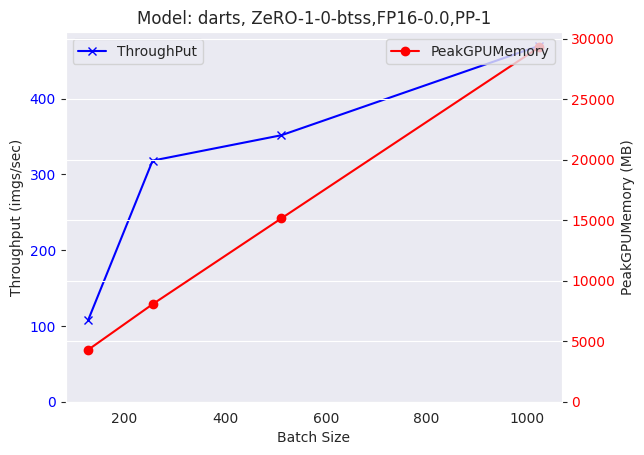

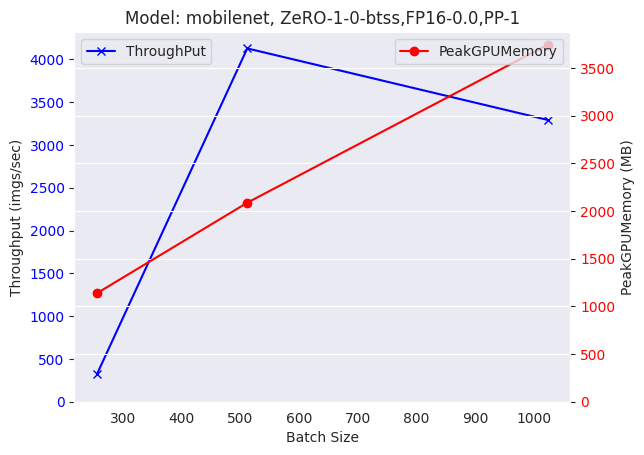

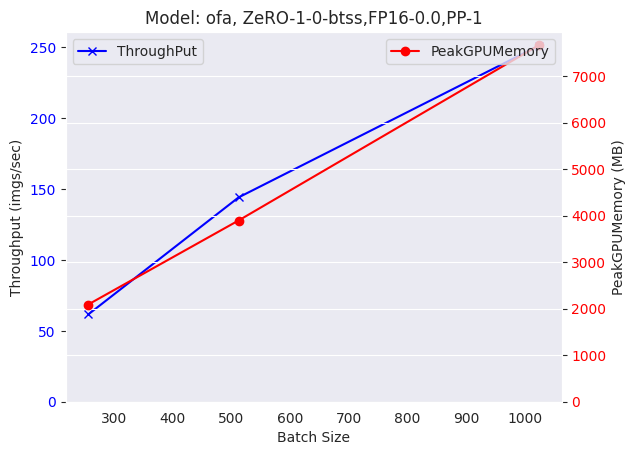

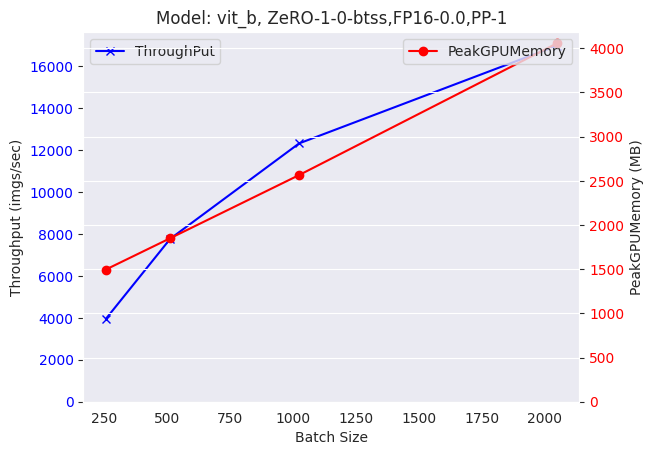

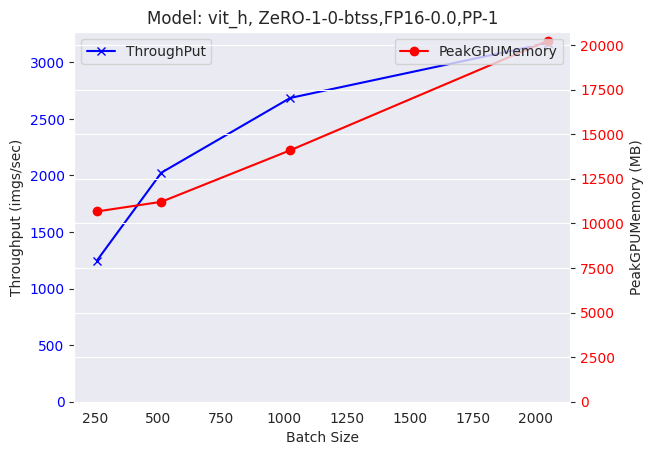

In [73]:

df = pd.read_csv("results.csv") # 读取 csv 文件

# 根据model和gpus进行分类
grouped = df.groupby(["model", "gpus"])

# 遍历每个分组，画出对应的图像
for group_name, group_data in grouped:
    model, gpus = group_name
    fig, ax1 = plt.subplots()

    # 对于每组数据，计算属性相同的ThroughPut和PeakGPUMemory_mean的均值和方差
    grouped_configs = group_data.groupby(["batch_size", "img_size", "zero", "shardstrategy", "nof", "fp16", "pipeline"])
    throughput_mean = grouped_configs["ThroughPut"].mean()
    throughput_std = grouped_configs["ThroughPut"].std()
    peak_memory_mean = grouped_configs["PeakGPUMemory_mean"].mean()
    peak_memory_std = grouped_configs["PeakGPUMemory_mean"].std()

    # 绘制ThroughPut的柱状图和误差线
    ax1.plot(throughput_mean.index.get_level_values("batch_size"), throughput_mean, color="blue", marker='x', label='ThroughPut')
    ax1.set_ylabel("Throughput (imgs/sec)")
    ax1.set_xlabel("Batch Size")
    ax1.set_ylim(bottom=0)
    ax1.tick_params(axis="y", labelcolor="blue")
    # ax1.tick_params(axis="x", labelrotation=90)
    # ax1.errorbar(x=throughput_mean.index.get_level_values("batch_size"), y=throughput_mean, yerr=throughput_std, color="black", fmt="none")

    # 绘制PeakGPUMemory_mean的折线图和误差线
    ax2 = ax1.twinx()
    ax2.plot(throughput_mean.index.get_level_values("batch_size"), peak_memory_mean, marker="o", color="red", label='PeakGPUMemory')
    # ax2.hist(throughput_mean.index.get_level_values("batch_size"), peak_memory_mean, color="red", label='PeakGPUMemory')
    ax2.set_ylabel("PeakGPUMemory (MB)")
    ax2.set_ylim(bottom=0)
    ax2.tick_params(axis="y", labelcolor="red")
    # ax2.errorbar(x=throughput_mean.index.get_level_values("batch_size"), y=peak_memory_mean, yerr=peak_memory_std, color="black", fmt="none")

    settings = [model, gpus] + list(next(iter(grouped_configs))[0])[2:]
    title = 'Model: {}, ZeRO-{}-{}-{},FP16-{},PP-{}'.format(*settings)
    plt.title(title)
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    ax1.grid()
    # display the plot
    plt.show()

darts has 1 exps


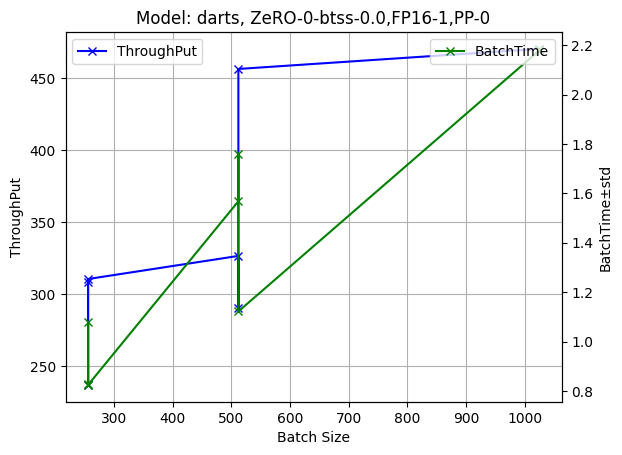

mobilenet has 1 exps


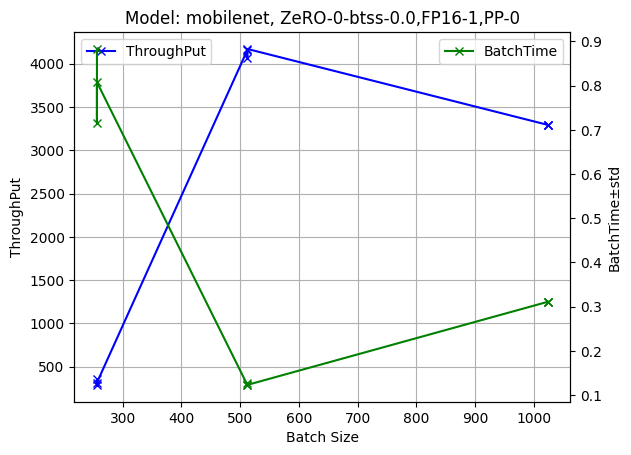

ofa has 1 exps


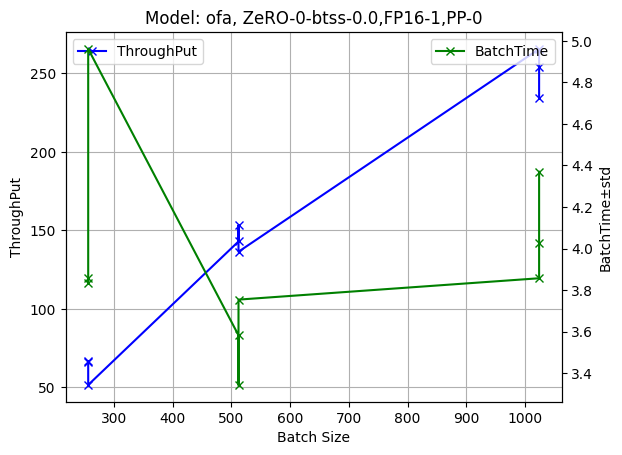

vit_b has 1 exps


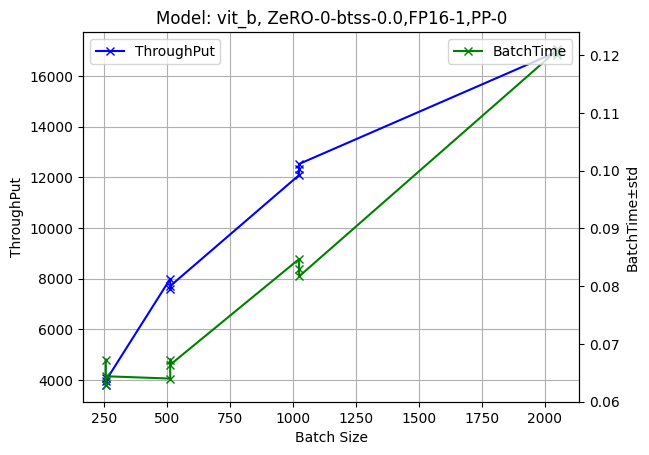

vit_h has 1 exps


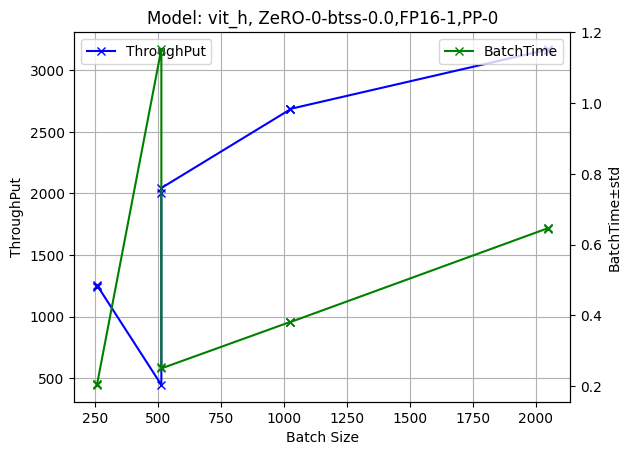

In [89]:

import matplotlib.pyplot as plt

df = df[df['ThroughPut']!=0]
grouped = df.groupby('model')

# plot a separate figure for each model
for name, group in grouped:
    # group the data by the parallelism settings
    subgroups = group.groupby(['zero', 'shardstrategy', 'nof', 'fp16', 'pipeline'])
    print(f"{name} has {len(subgroups)} exps")
    
    # plot a separate subplot for each group of parallelism settings
    for i, (settings, subgroup) in enumerate(subgroups):
        # create a subplot with two y-axes
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        
        # plot the ThroughPut data on the left y-axis
        ax1.plot(subgroup['batch_size'], subgroup['ThroughPut'], 'b-x', label='ThroughPut')
        ax1.set_xlabel('Batch Size')
        ax1.set_ylabel('ThroughPut')
        
        # plot the BatchTime_mean and BatchTime_std data on the right y-axis
        ax2.plot(subgroup['batch_size'], subgroup['BatchTime_mean'], 'g-x', label='BatchTime')
        # ax2.errorbar(subgroup['batch_size'], subgroup['BatchTime_mean'], yerr=subgroup['BatchTime_std'], fmt='r^', label='BatchTime_mean')
        ax2.set_ylabel('BatchTime±std')
        
        # add a legend and title to the plot
        settings = list([name] + list(settings))
        title = 'Model: {}, ZeRO-{}-{}-{},FP16-{},PP-{}'.format(*settings)
        plt.title(title)
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        
        ax1.grid()
        # display the plot
        plt.show()